# Imports

In [55]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn theme
sns.set_theme(style="darkgrid")

# Constants definition
ROOT_DIR = '../'
DATASETS_DIR = os.path.join(ROOT_DIR, 'datasets')
KPMG_DATASET_PATH = os.path.join(DATASETS_DIR, 'KPMG_VI_New_raw_data_update_final.xlsx')

# Load datasets

Import datasets from the diferent excel sheets. Skipping first row when needed.

In [56]:
# Import datasets from all excel sheets
df_transactions = pd.read_excel(KPMG_DATASET_PATH, "Transactions", skiprows=[0])
df_target_customers = pd.read_excel(KPMG_DATASET_PATH, "NewCustomerList", skiprows=[0])
df_customer_demographic = pd.read_excel(KPMG_DATASET_PATH, "CustomerDemographic")
df_customer_address = pd.read_excel(KPMG_DATASET_PATH, "CustomerAddress", skiprows=[0])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3712\3925331198.py:3: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_target_customers = pd.read_excel(KPMG_DATASET_PATH, "NewCustomerList", skiprows=[0])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3712\3925331198.py:4: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_customer_demographic = pd.read_excel(KPMG_DATASET_PATH, "CustomerDemographic")


# Transactions

## Preprocessing
Let's explore transactions dataframe.

In [57]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

We can see 360 null values in "online_order" and 197 null values on "brand", "product_line", "product_class", "product_size", "standard_cost" and "product_first_sold_date".

In [58]:
df_transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [59]:
df_transactions.describe()

,transaction_id,product_id,customer_id,online_order,list_price,standard_cost,product_first_sold_date
count,20000.000000,20000.00000,20000.000000,19640.000000,20000.000000,19803.000000,19803.000000
mean,10000.500000,45.36465,1738.246050,0.500458,1107.829449,556.046951,38199.776549
std,5773.647028,30.75359,1011.951046,0.500013,582.825242,405.955660,2875.201110
min,1.000000,0.00000,1.000000,0.000000,12.010000,7.210000,33259.000000
25%,5000.750000,18.00000,857.750000,0.000000,575.270000,215.140000,35667.000000
50%,10000.500000,44.00000,1736.000000,1.000000,1163.890000,507.580000,38216.000000
75%,15000.250000,72.00000,2613.000000,1.000000,1635.300000,795.100000,40672.000000
max,20000.000000,100.00000,5034.000000,1.000000,2091.470000,1759.850000,42710.000000


Let's change 'online_order' column type to boolean.

In [60]:
df_transactions["online_order"] = df_transactions["online_order"].astype('bool')
df_transactions["online_order"].value_counts()

True     10189
False     9811
Name: online_order, dtype: int64

Let's change 'order_status' column type to categorical.

In [61]:
df_transactions["order_status"] = df_transactions["order_status"].astype('category')
df_transactions["order_status"].dtype

CategoricalDtype(categories=['Approved', 'Cancelled'], ordered=False)

We explored the dataset, and "product_id" column is not realible, so let's drop it.

In [62]:
df_transactions.drop("product_id", axis=1, inplace=True)

It is safe to drop registers without product info (brand, product_line, etc) because represents less than %1 of the dataset (197 from 20000).

In [63]:
df_transactions = df_transactions[df_transactions['brand'].notna()]
df_transactions[df_transactions["brand"].isna()]

,transaction_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date


In order to normalize the data, let's extract product information and put it into a df_products dataframe.

Let's also create a new product_id column.

In [64]:
df_products = df_transactions[["transaction_id", "brand", "product_line", "product_class", "product_size"]]
df_products = df_products.groupby(["brand", "product_line", "product_class", "product_size"]).size().reset_index()
df_products.drop(0, axis=1, inplace=True)
df_products.reset_index(inplace=True)
df_products.rename(columns={"index" : "product_id"}, inplace=True)
df_products.head()

,product_id,brand,product_line,product_class,product_size
0,0,Giant Bicycles,Road,low,small
1,1,Giant Bicycles,Road,medium,medium
2,2,Giant Bicycles,Standard,high,medium
3,3,Giant Bicycles,Standard,high,small
4,4,Giant Bicycles,Standard,medium,large


Now we have a products dataframe, let's merge it with transactions dataframe on product information columns ("brand", "product_line", "product_class", "product_size").

This will generate us a "product_id" column that properly link both tables.

In [65]:
df_transactions = df_transactions.merge(df_products, how='left', on=["brand", "product_line", "product_class", "product_size"])

In [66]:
df_transactions.head()

,transaction_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,product_id
0,1,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,31
1,2,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,40
2,3,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0,21
3,4,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0,15
4,5,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0,4


With the product_id successfully added, we can now safely drop product related columns.

In [67]:
df_transactions.drop(["brand", "product_line", "product_class", "product_size"], axis=1, inplace=True)

In [68]:
df_transactions.head()

,transaction_id,customer_id,transaction_date,online_order,order_status,list_price,standard_cost,product_first_sold_date,product_id
0,1,2950,2017-02-25,False,Approved,71.49,53.62,41245.0,31
1,2,3120,2017-05-21,True,Approved,2091.47,388.92,41701.0,40
2,3,402,2017-10-16,False,Approved,1793.43,248.82,36361.0,21
3,4,3135,2017-08-31,False,Approved,1198.46,381.10,36145.0,15
4,5,787,2017-10-01,True,Approved,1765.30,709.48,42226.0,4


## Final dataframe structure

This is the final transactions dataframe:

In [69]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19803 entries, 0 to 19802
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           19803 non-null  int64         
 1   customer_id              19803 non-null  int64         
 2   transaction_date         19803 non-null  datetime64[ns]
 3   online_order             19803 non-null  bool          
 4   order_status             19803 non-null  category      
 5   list_price               19803 non-null  float64       
 6   standard_cost            19803 non-null  float64       
 7   product_first_sold_date  19803 non-null  float64       
 8   product_id               19803 non-null  int64         
dtypes: bool(1), category(1), datetime64[ns](1), float64(3), int64(3)
memory usage: 1.2 MB


## Visualizations
Now that we have a proper transactions dataframe, let's explore it a little.


How did the transactions behave over time?

In [70]:
df_transactions["transaction_date"].min(),  df_transactions["transaction_date"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2017-12-30 00:00:00'))

Since this dataset contains data only from 2017, let's quickly create a 'month' column in order to group data by it, and plot transaction count per month.

In [71]:
# Add month column
df_transactions['month'] = df_transactions["transaction_date"].dt.month
# Dataframe grouping by month
df_transactions_per_month = df_transactions.groupby("month").size().reset_index()
df_transactions_per_month.columns = ["month", "transaction_count"]
df_transactions_per_month

,month,transaction_count
0,1,1665
1,2,1612
2,3,1629
3,4,1641
4,5,1666
5,6,1564
6,7,1700
7,8,1735
8,9,1559
9,10,1751


Text(0.5, 1.0, 'Transactions accross 2017')

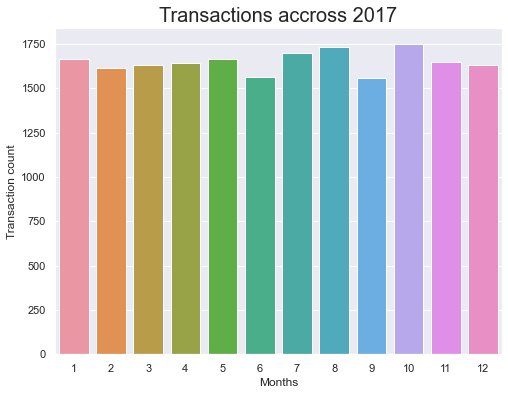

In [72]:
# Countplot
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.countplot(x=df_transactions["transaction_date"].dt.month, data=df_transactions)
ax.set_ylabel("Transaction count")
ax.set_xlabel("Months")
ax.set_title("Transactions accross 2017", fontsize=20)

How many online and not online orders we have?

In [73]:
df_transactions.groupby("online_order").size()

online_order
False     9706
True     10097
dtype: int64

Pretty even, how about order status?

In [74]:
df_transactions.groupby("order_status").size()

order_status
Approved     19625
Cancelled      178
dtype: int64

Less than 1% of the orders were cancelled.

Let's look at list_price and standard_cost distribution.

In [75]:
df_transactions[["list_price", "standard_cost"]].describe()

,list_price,standard_cost
count,19803.000000,19803.000000
mean,1107.997866,556.046951
std,582.770460,405.955660
min,12.010000,7.210000
25%,575.270000,215.140000
50%,1163.890000,507.580000
75%,1635.300000,795.100000
max,2091.470000,1759.850000


The distributions look pretty balanced. Let's look if there is a correlation between both.

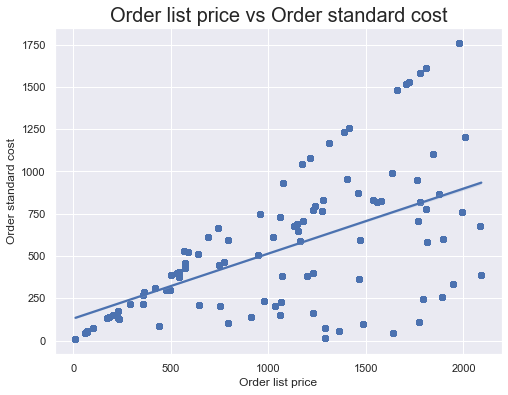

In [76]:
# Regplot
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.regplot(x="list_price", y="standard_cost", data=df_transactions)
ax.set_ylabel("Order standard cost")
ax.set_xlabel("Order list price")
ax.set_title("Order list price vs Order standard cost", fontsize=20)
plt.show()

There is a light positive correlation between order list price and order standard cost.

We can also see that list price is basically never lower that the standard cost, wich makes sense.

# Products

## Final dataframe structure

Now that we have our products dataset, let's explore it.

In [77]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49 non-null     int64 
 1   brand          49 non-null     object
 2   product_line   49 non-null     object
 3   product_class  49 non-null     object
 4   product_size   49 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.0+ KB


In [78]:
df_products.head()

,product_id,brand,product_line,product_class,product_size
0,0,Giant Bicycles,Road,low,small
1,1,Giant Bicycles,Road,medium,medium
2,2,Giant Bicycles,Standard,high,medium
3,3,Giant Bicycles,Standard,high,small
4,4,Giant Bicycles,Standard,medium,large


## Visualizations
How many products per brand and product_line are there?

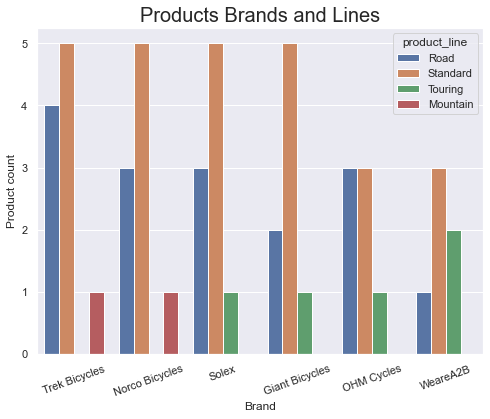

In [79]:
# Countplot
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.countplot(
    data=df_products,
    x="brand",
    order = df_products['brand'].value_counts().index,
    hue="product_line"
)
ax.set_ylabel("Product count")
ax.set_xlabel("Brand")
ax.set_title("Products Brands and Lines", fontsize=20)
plt.xticks(rotation = 20)
plt.show()

It seems that the best selling product lines are 'Road' and 'Standard'.

Furthermore, it can be seen that only the top 2 selling brands have sold the 'Mountain' product line.

At the same time, only the other 4 remaining brands have sold the 'Touring' product line.

# Customers
We have 3 customers datasets. Let's explore them.

## Customer address

This dataset contains information about customer's locations.

In [80]:
df_customer_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


In [81]:
df_customer_address.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [82]:
df_customer_address.describe()

,customer_id,postcode,property_valuation
count,3999.000000,3999.000000,3999.000000
mean,2003.987997,2985.755939,7.514379
std,1154.576912,844.878364,2.824663
min,1.000000,2000.000000,1.000000
25%,1004.500000,2200.000000,6.000000
50%,2004.000000,2768.000000,8.000000
75%,3003.500000,3750.000000,10.000000
max,4003.000000,4883.000000,12.000000


## Customer demographic

This dataset contains information about customer's demographics (gender, age, birth date).

In [83]:
df_customer_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   name                                 4000 non-null   object        
 2   gender                               4000 non-null   object        
 3   past_3_years_bike_related_purchases  4000 non-null   int64         
 4   DOB                                  3913 non-null   datetime64[ns]
 5   age                                  3999 non-null   float64       
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  owns_car    

In [84]:
df_customer_demographic.head()

,customer_id,name,gender,past_3_years_bike_related_purchases,DOB,age,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,34,Jephthah Bachmann,U,59,1843-12-21,NaN,Legal Assistant,IT,Affluent Customer,N,No,20.0
1,144,Jory Barrabeale,U,71,NaT,120.0,Environmental Tech,IT,Mass Customer,N,No,NaN
2,168,Reggie Broggetti,U,8,NaT,120.0,General Manager,IT,Affluent Customer,N,Yes,NaN
3,267,Edgar Buckler,U,53,NaT,120.0,NaN,IT,High Net Worth,N,No,NaN
4,290,Giorgio Kevane,U,42,NaT,120.0,Senior Sales Associate,IT,Mass Customer,N,No,NaN


In [85]:
df_customer_demographic.describe()

,customer_id,past_3_years_bike_related_purchases,age,tenure
count,4000.000000,4000.000000,3999.000000,3913.000000
mean,2000.500000,48.890000,44.054514,10.657041
std,1154.844867,28.715005,16.858429,5.660146
min,1.000000,0.000000,18.000000,1.000000
25%,1000.750000,24.000000,33.000000,6.000000
50%,2000.500000,48.000000,43.000000,11.000000
75%,3000.250000,73.000000,53.000000,15.000000
max,4000.000000,99.000000,120.000000,22.000000


## Target Customers
This dataset is about people that could be potential customers.

In [86]:
df_target_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   object        
 3   past_3_years_bike_related_purchases  1000 non-null   int64         
 4   DOB                                  983 non-null    datetime64[ns]
 5   job_title                            894 non-null    object        
 6   job_industry_category                835 non-null    object        
 7   wealth_segment                       1000 non-null   object        
 8   deceased_indicator                   1000 non-null   object        
 9   owns_car                             1000 non-null   object        
 10  tenure       

We have some null values on "last_name", birth date and job related columns.

In [87]:
df_target_customers.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.43,0.5375,0.671875,0.571094,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.58,0.5800,0.725000,0.616250,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,0.73,0.7300,0.730000,0.730000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.80,1.0000,1.000000,1.000000,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.80,0.8000,1.000000,1.000000,4,4,1.703125


We can drop "Unnamed", "Rank" and "Value" columns since they dont give us any useful information.

In [88]:
df_target_customers = df_target_customers.iloc[:, :-7]
df_target_customers.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,14,45 Shopko Center,4500,QLD,Australia,6
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,16,14 Mccormick Park,2113,NSW,Australia,11
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,10,5 Colorado Crossing,3505,VIC,Australia,5
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,5,207 Annamark Plaza,4814,QLD,Australia,1
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,19,115 Montana Place,2093,NSW,Australia,9


In [89]:
df_target_customers.describe()

,past_3_years_bike_related_purchases,tenure,postcode,property_valuation
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.836000,11.388000,3019.227000,7.397000
std,27.796686,5.037145,848.895767,2.758804
min,0.000000,0.000000,2000.000000,1.000000
25%,26.750000,7.000000,2209.000000,6.000000
50%,51.000000,11.000000,2800.000000,8.000000
75%,72.000000,15.000000,3845.500000,9.000000
max,99.000000,22.000000,4879.000000,12.000000


Let's fix some column types and names.

In [90]:
# Fix column types
df_target_customers["gender"] = df_target_customers["gender"].astype('category')
df_target_customers["owns_car"] = df_target_customers["owns_car"].astype('bool')
# Rename columns
df_target_customers.rename({'DOB' : 'birth_date'}, axis=1, inplace=True)

### Final dataframe structure

This is the final target customers dataframe:

In [91]:
df_target_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   category      
 3   past_3_years_bike_related_purchases  1000 non-null   int64         
 4   birth_date                           983 non-null    datetime64[ns]
 5   job_title                            894 non-null    object        
 6   job_industry_category                835 non-null    object        
 7   wealth_segment                       1000 non-null   object        
 8   deceased_indicator                   1000 non-null   object        
 9   owns_car                             1000 non-null   bool          
 10  tenure       

Let's test some merges to find matchs with 'customer_address' dataset.

First, create a 'full_name' column on customers dataframe, since it doesn't have a 'customer_id' column.

In [92]:
df_target_customers["full_name"] = df_target_customers["first_name"] + ' ' + df_target_customers["last_name"] 

In [93]:
df_target_customers.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,birth_date,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,full_name
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,True,14,45 Shopko Center,4500,QLD,Australia,6,Chickie Brister
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,True,16,14 Mccormick Park,2113,NSW,Australia,11,Morly Genery
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,True,10,5 Colorado Crossing,3505,VIC,Australia,5,Ardelis Forrester
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,True,5,207 Annamark Plaza,4814,QLD,Australia,1,Lucine Stutt
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,True,19,115 Montana Place,2093,NSW,Australia,9,Melinda Hadlee


Now we can find matchs.

In [94]:
df_merged = df_target_customers.merge(df_customer_demographic, how='inner', left_on='full_name', right_on='name')
df_merged.head()

,first_name,last_name,gender_x,past_3_years_bike_related_purchases_x,birth_date,job_title_x,job_industry_category_x,wealth_segment_x,deceased_indicator_x,owns_car_x,...,gender_y,past_3_years_bike_related_purchases_y,DOB,age,job_title_y,job_industry_category_y,wealth_segment_y,deceased_indicator_y,owns_car_y,tenure_y


There are no matchs like expected. So we can confirm that this dataset is about target customers, not current ones.

## Current Customers

Let's merge 'df_customer_demographic' with 'df_customer_address' into one unique and normalized customers dataframe called 'df_customers'.

In [110]:
df_customers = df_customer_demographic.merge(df_customer_address, on='customer_id', how='left')
df_customers.head()

,customer_id,name,gender,past_3_years_bike_related_purchases,DOB,age,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation
0,34,Jephthah Bachmann,U,59,1843-12-21,NaN,Legal Assistant,IT,Affluent Customer,N,No,20.0,833 Luster Way,4005.0,QLD,Australia,8.0
1,144,Jory Barrabeale,U,71,NaT,120.0,Environmental Tech,IT,Mass Customer,N,No,NaN,22 Oxford Junction,2315.0,New South Wales,Australia,3.0
2,168,Reggie Broggetti,U,8,NaT,120.0,General Manager,IT,Affluent Customer,N,Yes,NaN,16 Golf View Center,3020.0,VIC,Australia,6.0
3,267,Edgar Buckler,U,53,NaT,120.0,NaN,IT,High Net Worth,N,No,NaN,48 Arizona Drive,2768.0,NSW,Australia,10.0
4,290,Giorgio Kevane,U,42,NaT,120.0,Senior Sales Associate,IT,Mass Customer,N,No,NaN,6923 Tennessee Circle,2766.0,NSW,Australia,9.0


In [96]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   name                                 4000 non-null   object        
 2   gender                               4000 non-null   object        
 3   past_3_years_bike_related_purchases  4000 non-null   int64         
 4   DOB                                  3913 non-null   datetime64[ns]
 5   age                                  3999 non-null   float64       
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  owns_car    

In [97]:
df_customers.describe()

,customer_id,past_3_years_bike_related_purchases,age,tenure,postcode,property_valuation
count,4000.000000,4000.000000,3999.000000,3913.000000,3996.000000,3996.000000
mean,2000.500000,48.890000,44.054514,10.657041,2985.735485,7.514014
std,1154.844867,28.715005,16.858429,5.660146,844.945641,2.825426
min,1.000000,0.000000,18.000000,1.000000,2000.000000,1.000000
25%,1000.750000,24.000000,33.000000,6.000000,2200.000000,6.000000
50%,2000.500000,48.000000,43.000000,11.000000,2768.000000,8.000000
75%,3000.250000,73.000000,53.000000,15.000000,3750.000000,10.000000
max,4000.000000,99.000000,120.000000,22.000000,4883.000000,12.000000


In [98]:
df_customers["customer_id"].unique().size

4000

It's a perfect merge.

Let's fix some column types and names.

In [99]:
# Fix column types
df_customers["gender"] = df_customers["gender"].astype('category')
df_customers["owns_car"] = df_customers["owns_car"].astype('bool')
# Rename columns
df_customers.rename({'DOB' : 'birth_date'}, axis=1, inplace=True)

### Final dataframe structure

This is the final customers dataframe:

In [100]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   name                                 4000 non-null   object        
 2   gender                               4000 non-null   category      
 3   past_3_years_bike_related_purchases  4000 non-null   int64         
 4   birth_date                           3913 non-null   datetime64[ns]
 5   age                                  3999 non-null   float64       
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  owns_car    

### Visualizations
Now we can explore it a little.

In [101]:
# Customers by gender
df_customers.groupby("gender").size()

gender
Female    2039
Male      1873
U           88
dtype: int64

We have 88 customers with 'U' gender. We can assume that stands for 'Unknown'.

In [102]:
# Filter unknown gender
df_customers_known_gender = df_customers[df_customers["gender"] != 'U']
df_customers_known_gender.groupby("gender").size()

gender
Female    2039
Male      1873
U            0
dtype: int64

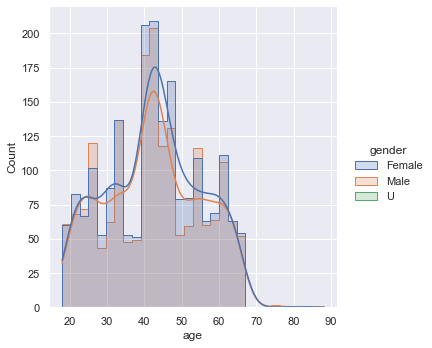

In [103]:
# Displot
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.displot(df_customers_known_gender, x="age", hue="gender", element='step', kde=True)
#ax.set_ylabel("Customer count")
# ax.set_xlabel("Age")
# ax.set_title("Current customers demogrhapic", fontsize=20)
plt.show()

It seems that the largest number of customers are in their 40's and 50's.

In addition, a small advantage can be observed in the number of female customers across most age ranges, but in general both genders are even.